# STL Model Creation -- with weather normalized data

Clayton Miller - miller.clayton@gmail.com

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import timeit
import os
from datetime import datetime
from __future__ import division
import matplotlib.dates as mdates
from matplotlib import ticker
import datetime
import matplotlib

In [2]:
import rpy2

In [3]:
sns.set_style("whitegrid")

In [4]:
%matplotlib inline

In [5]:
%load_ext rpy2.ipython 

In [6]:
from pylab import *

In [7]:
%matplotlib inline

In [12]:
repos_path = "/Users/Clayton/temporal-features-for-buildings/"

In [13]:
meta = pd.read_csv(os.path.join(repos_path,"data/raw/meta_open.csv"), index_col='uid', parse_dates=["datastart","dataend"], dayfirst=True)

In [14]:
temp = pd.read_csv((os.path.join(repos_path,"data/interim/temp_open_utc_complete.csv")), index_col='timestamp', parse_dates=True).tz_localize('utc')
temp_modelheating = pd.read_csv(os.path.join(repos_path,"data/interim/temp_eemeter_predictedheating.csv"), index_col='timestamp', parse_dates=True)
temp_modelcooling = pd.read_csv(os.path.join(repos_path,"data/interim/temp_eemeter_predictedcooling.csv"), index_col='timestamp', parse_dates=True)

# One example STL model -- removing the heating and cooling components

In [15]:
%%R 
library(forecast)
library(stats)

In [16]:
meta.head()

,dataend,datastart,energystarscore,heatingtype,industry,mainheatingtype,numberoffloors,occupants,primaryspaceusage,rating,sqft,sqm,subindustry,timezone,yearbuilt,nickname,primaryspaceuse_abbrev,newweatherfilename
uid,,,,,,,,,,,,,,,,,,
PrimClass_Everett,2012-12-31 23:00:00,2012-01-01,NaN,NaN,Education,NaN,NaN,NaN,Primary/Secondary Classroom,NaN,105530.0,9804.053590,Primary/Secondary School,America/New_York,NaN,Everett,PrimClass,weather12.csv
UnivClass_Clifford,2015-12-31 23:00:00,2015-01-01,NaN,NaN,Education,NaN,NaN,NaN,College Classroom,NaN,56969.0,5292.591007,College/University,America/New_York,1967,Clifford,UnivClass,weather2.csv
Office_Elizabeth,2012-12-31 23:00:00,2012-01-01,NaN,NaN,Commercial Property,NaN,NaN,NaN,Office,NaN,294651.0,27373.961850,Commercial Real Estate,America/Los_Angeles,NaN,Elizabeth,Office,weather22.csv
Office_Ellie,2012-12-31 23:00:00,2012-01-01,NaN,NaN,Commercial Property,NaN,NaN,NaN,Office,NaN,496517.0,46127.918850,Bank/Financial Services,America/Los_Angeles,NaN,Ellie,Office,weather28.csv
PrimClass_Elisabeth,2012-12-31 23:00:00,2012-01-01,NaN,NaN,Education,NaN,NaN,NaN,Primary/Secondary Classroom,NaN,233062.0,21652.158990,Primary/Secondary School,America/New_York,NaN,Elisabeth,PrimClass,weather23.csv


In [17]:
building = "PrimClass_Everett"

In [18]:
timezone = meta.T[building].timezone
start = meta.T[building].datastart
end = meta.T[building].dataend
building_data = temp[building].tz_convert(timezone).truncate(before=start,after=end).resample('D').sum().tz_localize(None)
building_data_cooling = temp_modelcooling[building].truncate(before=start,after=end).fillna(0)
building_data_heating = temp_modelheating[building].truncate(before=start,after=end).fillna(0)
building_data_weathernormalized = building_data - building_data_cooling - building_data_heating
data = building_data_weathernormalized.reset_index(drop=True)

year = start.year
month = start.month
day = start.day

In [19]:
%Rpush data
%Rpush year
%Rpush month
%Rpush day


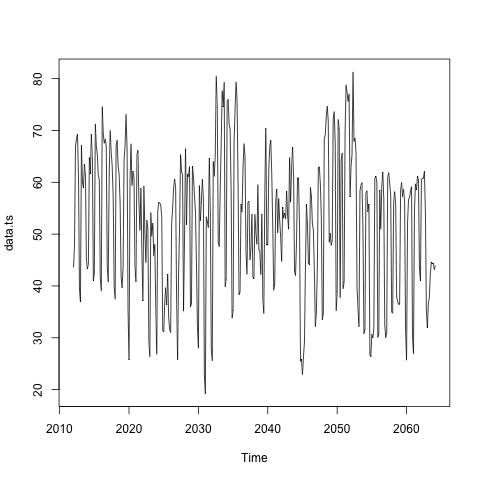

In [20]:
%R df <- as.numeric(data)
%R data <- unname(df, force = FALSE)
%R data.ts <- ts(data, start=c(year,month,day), freq=7)
%R plot(data.ts)

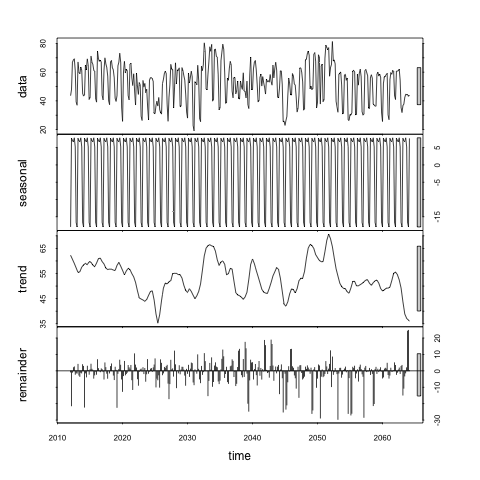

In [21]:
%R data.stl <- stl(data.ts, s.window="periodic", robust=TRUE)
%R plot(data.stl)

In [22]:
%R remainder <- data.stl$time.series[,"remainder"]
%R trend <- data.stl$time.series[,"trend"]
%R seasonal <- data.stl$time.series[,"seasonal"]

%Rpull remainder
%Rpull trend
%Rpull seasonal

In [23]:
remainder = pd.DataFrame({building:remainder}, index=building_data.index).tz_localize(None)
trend = pd.DataFrame({building:trend}, index=building_data.index).tz_localize(None)
seasonal = pd.DataFrame({building:seasonal}, index=building_data.index).tz_localize(None)

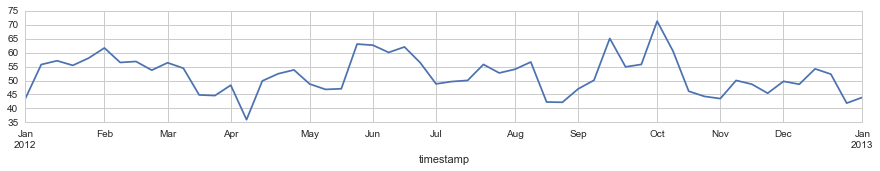

In [24]:
building_data_weathernormalized.resample("W").mean().plot(figsize=(15,2));

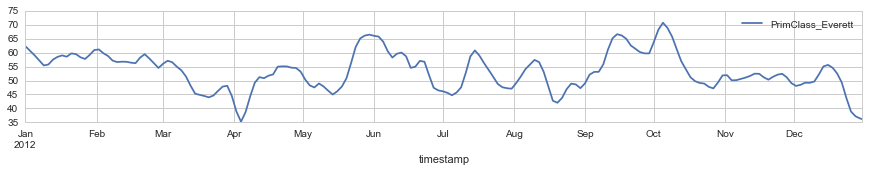

In [25]:
trend.plot(figsize=(15,2));

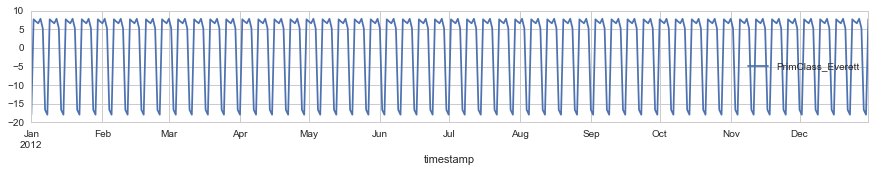

In [26]:
seasonal.plot(figsize=(15,2));

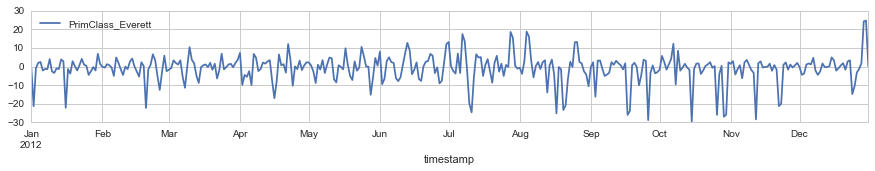

In [27]:
remainder.plot(figsize=(15,2));

In [28]:
def decompose_building(temp, meta, building):
    
    timezone = meta.T[building].timezone
    start = meta.T[building].datastart
    end = meta.T[building].dataend
    building_data = temp[building].tz_convert(timezone).truncate(before=start,after=end).resample('D').sum().tz_localize(None)
    building_data_cooling = temp_modelcooling[building].truncate(before=start,after=end).fillna(0)
    building_data_heating = temp_modelheating[building].truncate(before=start,after=end).fillna(0)
    building_data_weathernormalized = building_data - building_data_cooling - building_data_heating
    data = building_data_weathernormalized.reset_index(drop=True)
    data = building_data.reset_index(drop=True)

    year = start.year
    month = start.month
    day = start.day

    %Rpush data
    %Rpush year
    %Rpush month
    %Rpush day

    %R df <- as.numeric(data)
    %R data <- unname(df, force = FALSE)
    %R data.ts <- ts(data, start=c(year,month,day), freq=7)
    %R data.stl <- stl(data.ts, s.window="periodic", robust=TRUE)

    %R remainder <- data.stl$time.series[,"remainder"]
    %R trend <- data.stl$time.series[,"trend"]
    %R seasonal <- data.stl$time.series[,"seasonal"]

    %Rpull remainder
    %Rpull trend
    %Rpull seasonal
    
    remainder_df = pd.DataFrame({building:remainder}, index=building_data.index).tz_localize(None)
    trend_df = pd.DataFrame({building:trend}, index=building_data.index).tz_localize(None)
    seasonal_df = pd.DataFrame({building:seasonal}, index=building_data.index).tz_localize(None)
    
    remainder_df = remainder_df/np.abs(building_data).max()
    trend_df = (trend_df - trend.min())/(trend_df.max()-trend.min())
    
    seasonal_weekdaymean = seasonal_df.groupby(seasonal_df.index.dayofweek).mean()
    seasonal_weekdaymean_normalized = (seasonal_weekdaymean - seasonal_weekdaymean.min())/(seasonal_weekdaymean.max()-seasonal_weekdaymean.min())

    weekdays = ["Mon","Tue","Wed","Thur","Fri","Sat","Sun"]
    seasonal_weekdaymean_normalized.index = weekdays
    
    return remainder_df, trend_df, seasonal_weekdaymean_normalized

In [29]:
remainder, trend, seasonal = decompose_building(temp, meta, building)

In [30]:
remainder.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 366 entries, 2012-01-01 to 2012-12-31
Freq: D
Data columns (total 1 columns):
PrimClass_Everett    366 non-null float64
dtypes: float64(1)
memory usage: 5.7 KB


In [31]:
def get_individual_data(temp, meta, building):
    timezone = meta.T[building].timezone
    start = meta.T[building].datastart
    end = meta.T[building].dataend
    return pd.DataFrame(temp[building].tz_convert(timezone).truncate(before=start,after=end))

def get_individual_data_notz(temp, meta, building):
    start = meta.T[building].datastart
    end = meta.T[building].dataend
    return pd.DataFrame(temp[building].truncate(before=start,after=end))

In [32]:
def plot_line_example(df_1, df_2, color, vartitle1, vartitle2):
    sns.set(rc={"figure.figsize": (12,4)})
    sns.set_style('whitegrid')
    fig = plt.figure()
    fig.autofmt_xdate()
    fig.subplots_adjust(hspace=.5)
    gs = GridSpec(100,100,bottom=0.18,left=0.18,right=0.88)
    
    df_1.columns = ["Actual kWh"]
    #df_predicted.columns = ["Predicted kWh"]
    ax1 = fig.add_subplot(gs[1:60,:])
    df_1.plot(ax = ax1, legend=False) # .resample("D").sum()
    ax1.xaxis.set_visible(False)
    ax1.set_title(vartitle1)
    
    ax2 = fig.add_subplot(gs[68:,:])
    #df_2 = df_2.tz_localize(None)
    x = mdates.drange(df_2.index[0], df_2.index[-1] + datetime.timedelta(days=1), datetime.timedelta(days=1))
    y = np.linspace(0, len(df_2.columns), len(df_2.columns)+1)
    data = np.array(df_2.T)
    datam = np.ma.array(data, mask=np.isnan(data))
    cmap = matplotlib.cm.get_cmap(color)
    
    qmesh = ax2.pcolormesh(x, y, datam, cmap=cmap)
    ax2.set_title(vartitle2)
    
    #leftspacing, 
    cbaxes = fig.add_axes([0.18, 0.08, 0.7, 0.02]) 
    cbar = fig.colorbar(qmesh, ax=ax2, orientation='horizontal', cax=cbaxes)
    tick_locator = ticker.MaxNLocator(nbins=7)
    cbar.locator = tick_locator
    cbar.update_ticks()
    
    ax2.axis('tight')
    ax2.xaxis_date()
    ax2.yaxis.set_visible(False)
    myFmt = mdates.DateFormatter('%b')
    ax2.xaxis.set_major_formatter(myFmt)

In [44]:
def plot_line_example_weekdays(df_1, df_2, color, vartitle):
    sns.set(rc={"figure.figsize": (12,4)})
    sns.set_style('whitegrid')
    fig = plt.figure()
    fig.subplots_adjust(hspace=.5)
    gs = GridSpec(100,100,bottom=0.18,left=0.18,right=0.88)
    
    df_1.columns = ["Actual kWh"]
    ax1 = fig.add_subplot(gs[1:60,:])
    df_1.plot(ax = ax1, legend=False) # .resample("D").sum()
    ax1.xaxis.set_visible(False)
    ax1.set_title("Daily kWh")
    
    ax2 = fig.add_subplot(gs[68:,:])
    #df_2 = df_2.tz_localize(None)
    x = np.linspace(0, len(df_2.index), len(df_2.index)+1)
    y = np.linspace(0, len(df_2.columns), len(df_2.columns)+1)
    data = np.array(df_2.T)
    datam = np.ma.array(data, mask=np.isnan(data))
    cmap = matplotlib.cm.get_cmap(color)
    
    qmesh = ax2.pcolormesh(x, y, datam, cmap=cmap)
    ax2.set_title(vartitle)
    
    ax2.xaxis.set(ticks=np.arange(0.5, len(df_2.index)), ticklabels=df_2.index)

    #leftspacing, 
    cbaxes = fig.add_axes([0.18, 0.08, 0.7, 0.02]) 
    cbar = fig.colorbar(qmesh, ax=ax2, orientation='horizontal', cax=cbaxes)
    tick_locator = ticker.MaxNLocator(nbins=7)
    cbar.locator = tick_locator
    cbar.update_ticks()
    
    ax2.axis('tight')
    ax2.yaxis.set_visible(False)


In [45]:
# start = '2015-07-01'
# end = '2015-09-30'

In [46]:
remainder.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 366 entries, 2012-01-01 to 2012-12-31
Freq: D
Data columns (total 1 columns):
PrimClass_Everett    366 non-null float64
dtypes: float64(1)
memory usage: 5.7 KB


In [47]:
df = building_data_weathernormalized
#df = get_individual_data(temp, meta, building)
#df = df.truncate(before=start,after=end)#
#breakout = breakout#.truncate(before=start,after=end)

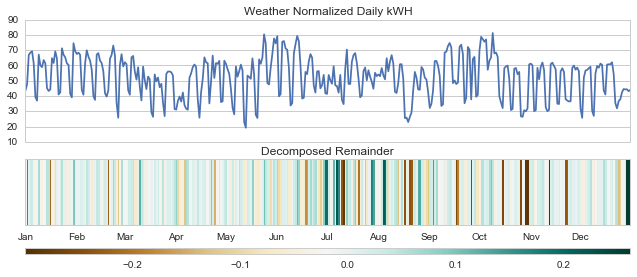

In [48]:
plot_line_example(df, remainder, "BrBG","Weather Normalized Daily kWH","Decomposed Remainder")
plt.savefig(os.path.join(repos_path,"reports/figures/featureoverviews/stl_weathernorm_remainder_example.png"));

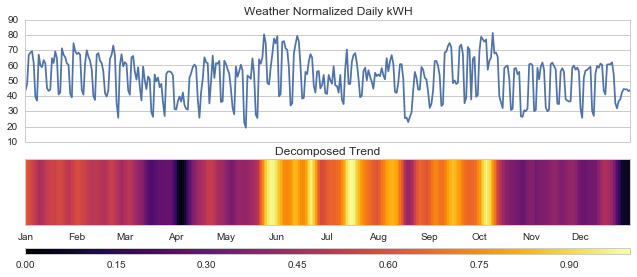

In [49]:
plot_line_example(df, trend, "inferno","Weather Normalized Daily kWH","Decomposed Trend")
plt.savefig(os.path.join(repos_path,"reports/figures/featureoverviews/stl_weathernorm_trend_example.png"));

In [50]:
seasonal

,Actual kWh
Mon,0.946174
Tue,0.983459
Wed,0.963590
Thur,1.000000
Fri,0.921512
Sat,0.054784
Sun,0.000000


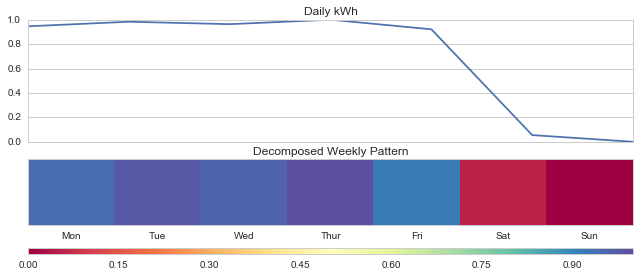

In [51]:
plot_line_example_weekdays(seasonal, seasonal, "Spectral","Decomposed Weekly Pattern")
plt.savefig(os.path.join(repos_path,"reports/figures/featureoverviews/stl_seasonal_example.png"));

In [52]:
building_data_weekdays = pd.DataFrame(building_data.groupby(building_data.index.dayofweek).mean())
building_data_weekdays_normalized = (building_data_weekdays - building_data_weekdays.min())/(building_data_weekdays.max()-building_data_weekdays.min())
weekdays = ["Mon","Tue","Wed","Thur","Fri","Sat","Sun"]
building_data_weekdays_normalized.index = weekdays

In [53]:
building_data_weekdays_normalized

,PrimClass_Everett
Mon,0.743758
Tue,0.895814
Wed,0.927937
Thur,1.000000
Fri,0.842896
Sat,0.076196
Sun,0.000000


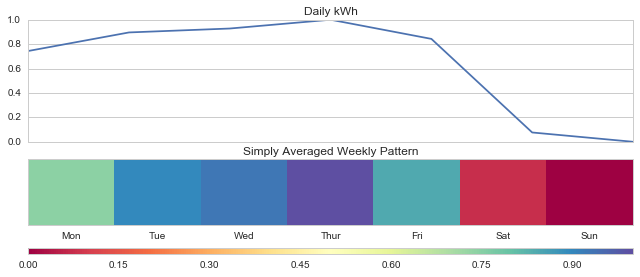

In [54]:
plot_line_example_weekdays(building_data_weekdays_normalized, building_data_weekdays_normalized, "Spectral","Simply Averaged Weekly Pattern")

# Loop though all buildings

In [40]:
overall_start_time = timeit.default_timer()

temp_remainder = pd.DataFrame()
temp_trend = pd.DataFrame()
temp_seasonal = pd.DataFrame()

for building in meta.index:
    remainder, trend, seasonal = decompose_building(temp, meta, building)
    temp_remainder = pd.merge(temp_remainder, remainder, right_index=True, left_index=True, how='outer')
    temp_trend = pd.merge(temp_trend, trend, right_index=True, left_index=True, how='outer')
    temp_seasonal = pd.merge(temp_seasonal, seasonal, right_index=True, left_index=True, how='outer')
    
print "Calculated all building in "+str(timeit.default_timer() - overall_start_time)+" seconds"


Calculated all building in 54.2556769848 seconds


In [41]:
temp_trend.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1706 entries, 2010-01-01 to 2015-12-31
Columns: 507 entries, PrimClass_Everett to UnivLab_Aoife
dtypes: float64(507)
memory usage: 6.6 MB


# Overview heatmap

In [46]:
def heatmap_data_weekday(df):
    x = np.linspace(0, len(df.index), len(df.index)+1)
    y = np.linspace(0, len(df.columns), len(df.columns)+1)
    return x,y

def heatmap_data(df):
    x = mdates.drange(df.index[0], df.index[-1] + datetime.timedelta(days=1), datetime.timedelta(days=1))
    y = np.linspace(0, len(df.columns), len(df.columns)+1)
    return x,y

#This function changes the year for all of the buildings so that they can be overlapped for plotting
# THE RESULTING DATAFRAME IS ONLY FOR "GENERALIZED" PLOTTING TO GET THE DATA SETS TO OVERLAP -- DON'T PERFORM CALCULATIONS ON IT

def changeto2015(x):
    try:
        return x.replace(year=2015)
    except:
        return np.nan
    
def is_leap_and_29Feb(s):
    return (s.index.year % 4 == 0) & ((s.index.year % 100 != 0) | (s.index.year % 400 == 0)) & (s.index.month == 2) & (s.index.day == 29)

def generalize_timestamp_forplotting(meta, temp):
    temp_generalized = pd.DataFrame()
    buildinglist = list(meta.index)
    
    for building in buildinglist:
        #Change to timezone
        timezone = meta.T[building].timezone
        start = meta.T[building].datastart
        end = meta.T[building].dataend
        building_data = pd.DataFrame(temp[building].tz_convert(timezone).truncate(before=start,after=end))
        
        #Remove leap year day for 2012
        mask = is_leap_and_29Feb(building_data)
        building_data = building_data.loc[~mask]
        
        #Change to 2015 -- we arbitrarily use this year
        building_data.index = building_data.index.map(lambda t: changeto2015(t))
        
        #Remove tz awareness, resample to normalize the timestamps and ffill to get rid of the gaps
        building_data = building_data.tz_localize(None)
        building_data = building_data.resample('D').mean().sort_index()
        building_data = building_data.ffill()
        
        #Merge into dataset
        temp_generalized = pd.merge(temp_generalized, building_data, right_index=True, left_index=True, how='outer')
        temp_generalized = temp_generalized.resample('D').mean().sort_index()
        
        #print "finished building: "+building
    return temp_generalized

def generalize_timestamp_forplotting_notz(meta, temp):
    temp_generalized = pd.DataFrame()
    buildinglist = list(meta.index)
    
    for building in buildinglist:
        #Change to timezone
        start = meta.T[building].datastart
        end = meta.T[building].dataend
        building_data = pd.DataFrame(temp[building].truncate(before=start,after=end))
        
        #Remove leap year day for 2012
        mask = is_leap_and_29Feb(building_data)
        building_data = building_data.loc[~mask]
        
        #Change to 2015 -- we arbitrarily use this year
        building_data.index = building_data.index.map(lambda t: changeto2015(t))
        
        #Remove tz awareness, resample to normalize the timestamps and ffill to get rid of the gaps
        building_data = building_data.tz_localize(None)
        building_data = building_data.resample('D').mean().sort_index()
        building_data = building_data.ffill()
        
        #Merge into dataset
        temp_generalized = pd.merge(temp_generalized, building_data, right_index=True, left_index=True, how='outer')
        temp_generalized = temp_generalized.resample('D').mean().sort_index()
        
        #print "finished building: "+building
    return temp_generalized

def plotmap(df, color, cbarlabel, xaxislabel, yaxislabel, graphiclabel, filelabel):
    
    import matplotlib.dates as mdates
    from matplotlib import ticker
    import datetime
    import matplotlib
    import seaborn as sns

    # Set up the size/style
    sns.set(rc={"figure.figsize": (12,15)})
    sns.set_style("whitegrid")
    
    numberofplots = 1
    fig = plt.figure()
    
    x = mdates.drange(df.index[0], df.index[-1] + datetime.timedelta(days=1), datetime.timedelta(days=1))
    y = np.linspace(0, len(df.columns), len(df.columns)+1)
    ax = fig.add_subplot(numberofplots, 1, 1)
    data = np.array(df.T)
    datam = np.ma.array(data, mask=np.isnan(data))
    cmap = matplotlib.cm.get_cmap(color)
    qmesh = ax.pcolormesh(x, y, datam, cmap=cmap)
    
    cbaxes = fig.add_axes([0.15, 0.15, 0.7, 0.02]) 
    cbar = fig.colorbar(qmesh, ax=ax, orientation='horizontal', cax=cbaxes)
    
    cbar.ax.tick_params(length = 0)
    cbar.set_label(cbarlabel)
    
    ax.axis('tight')
    ax.xaxis_date()
    fig.autofmt_xdate()
    fig.subplots_adjust(hspace=.5)
    ax.set_xlabel(xaxislabel)
    ax.set_ylabel(yaxislabel)
    ax.set_title(graphiclabel)
    
    ax.set_yticklabels(df.columns)
    tick_locator = ticker.MaxNLocator(nbins=110)
    loc = ticker.MultipleLocator(base=1.0) # this locator puts ticks at regular intervals
    ax.locator_params(axis='y', nbins=100)
    myFmt = mdates.DateFormatter('%b')
    ax.xaxis.set_major_formatter(myFmt)
    
    plt.subplots_adjust(bottom=0.2)

def plotmap_subplots(df, meta, color, cbarlabel, xaxislabel, yaxislabel, graphiclabel, filelabel, z_min, z_max):

    import matplotlib.dates as mdates
    from matplotlib import ticker
    import datetime
    import matplotlib
    import seaborn as sns

    # Set up the size/style
    sns.set(rc={"figure.figsize": (12,15)})
    sns.set_style("whitegrid")
    cmap = matplotlib.cm.get_cmap(color)
    
    fig = plt.figure()
    fig.autofmt_xdate()
    fig.subplots_adjust(hspace=.5)
    gs = GridSpec(100,100,bottom=0.18,left=0.18,right=0.88)
    
    # Plot Offices
    df_office = df[df.columns[df.columns.str.contains("Office")]]
    office_height = int(len(df_office.T)/len(df.T)*100-2)
    ax1 = fig.add_subplot(gs[1:office_height,:])
    x,y = heatmap_data(df_office)
    data = np.array(df_office.T)
    datam = np.ma.array(data, mask=np.isnan(df_office))
    qmesh = ax1.pcolormesh(x, y, datam, cmap=cmap, vmin=z_min, vmax=z_max)
    ax1.axis('tight')
    #ax1.xaxis_date()
    ax1.set_title("Offices")
    ax1.xaxis.set_visible(False)
    
    # Plot UnivLab
    df_lab = df[df.columns[df.columns.str.contains("UnivLab")]]
    lab_height = int(len(df_lab.T)/len(df.T)*100-2)
    ax2 = fig.add_subplot(gs[office_height+2:office_height+lab_height,:])
    x,y = heatmap_data(df_lab)
    data = np.array(df_lab.T)
    datam = np.ma.array(data, mask=np.isnan(df_lab))
    qmesh = ax2.pcolormesh(x, y, datam, cmap=cmap, vmin=z_min, vmax=z_max)
    ax2.axis('tight')
    #ax2.xaxis_date()
    ax2.set_title("University Labs")
    ax2.xaxis.set_visible(False)
    
    # Plot UnivClass
    df_uniclass = df[df.columns[df.columns.str.contains("UnivClass")]]
    uniclass_height = int(len(df_uniclass.T)/len(df.T)*100-2)
    ax3 = fig.add_subplot(gs[office_height+lab_height+2:office_height+lab_height+uniclass_height,:])
    x,y = heatmap_data(df_uniclass)
    data = np.array(df_uniclass.T)
    datam = np.ma.array(data, mask=np.isnan(df_uniclass))
    qmesh = ax3.pcolormesh(x, y, datam, cmap=cmap, vmin=z_min, vmax=z_max)
    ax3.axis('tight')
    #ax3.xaxis_date()
    ax3.set_title("University Classrooms")
    ax3.xaxis.set_visible(False)

    # Plot PrimClass
    df_primclass = df[df.columns[df.columns.str.contains("PrimClass")]]
    primclass_height = int(len(df_primclass.T)/len(df.T)*100-2)
    ax4 = fig.add_subplot(gs[office_height+lab_height+uniclass_height+2:office_height+lab_height+uniclass_height+primclass_height,:])
    x,y = heatmap_data(df_primclass)
    data = np.array(df_primclass.T)
    datam = np.ma.array(data, mask=np.isnan(df_primclass))
    qmesh = ax4.pcolormesh(x, y, datam, cmap=cmap, vmin=z_min, vmax=z_max)
    ax4.axis('tight')
    #ax4.xaxis_date()
    ax4.set_title("Primary/Secondary Classroom")
    ax4.xaxis.set_visible(False)

    
    # Plot Univ Dorms
    df_unidorm = df[df.columns[df.columns.str.contains("UnivDorm")]]
    unidorm_height = int(len(df_unidorm.T)/len(df.T)*100-2)
    ax5 = fig.add_subplot(gs[office_height+lab_height+uniclass_height+primclass_height+2:office_height+lab_height+uniclass_height+primclass_height+unidorm_height,:])
    x,y = heatmap_data(df_unidorm)
    data = np.array(df_unidorm.T)
    datam = np.ma.array(data, mask=np.isnan(df_unidorm))
    qmesh = ax5.pcolormesh(x, y, datam, cmap=cmap, vmin=z_min, vmax=z_max)
    ax5.axis('tight')
    #ax5.xaxis_date()
    ax5.set_title("University Dorms")
    
    cbaxes = fig.add_axes([0.18, 0.23, 0.7, 0.02]) 
    cbar = fig.colorbar(qmesh, orientation='horizontal', cax=cbaxes) #ax=ax,
    
    cbar.ax.tick_params(length = 0)
    cbar.set_label(cbarlabel)

    myFmt = mdates.DateFormatter('%b')
    months = MonthLocator()
    ax5.xaxis.set_major_locator(months)
    ax5.xaxis.set_major_formatter(myFmt)
    
    fig.text(0.14, 0.6, yaxislabel, va='center', rotation='vertical')    

def plotmap_subplots_weekdays(df, meta, color, cbarlabel, xaxislabel, yaxislabel, graphiclabel, filelabel, z_min, z_max):

    import matplotlib.dates as mdates
    from matplotlib import ticker
    import datetime
    import matplotlib
    import seaborn as sns

    # Set up the size/style
    sns.set(rc={"figure.figsize": (12,15)})
    sns.set_style("whitegrid")
    cmap = matplotlib.cm.get_cmap(color)
    
    fig = plt.figure()
    fig.autofmt_xdate()
    fig.subplots_adjust(hspace=.5)
    gs = GridSpec(100,100,bottom=0.18,left=0.18,right=0.88)
    
    # Plot Offices
    df_office = df[df.columns[df.columns.str.contains("Office")]]
    office_height = int(len(df_office.T)/len(df.T)*100-2)
    ax1 = fig.add_subplot(gs[1:office_height,:])
    x,y = heatmap_data_weekday(df_office)
    data = np.array(df_office.T)
    datam = np.ma.array(data, mask=np.isnan(df_office))
    qmesh = ax1.pcolormesh(x, y, datam, cmap=cmap, vmin=z_min, vmax=z_max)
    ax1.axis('tight')
    #ax1.xaxis_date()
    ax1.set_title("Offices")
    ax1.xaxis.set_visible(False)
    
    # Plot UnivLab
    df_lab = df[df.columns[df.columns.str.contains("UnivLab")]]
    lab_height = int(len(df_lab.T)/len(df.T)*100-2)
    ax2 = fig.add_subplot(gs[office_height+2:office_height+lab_height,:])
    x,y = heatmap_data_weekday(df_lab)
    data = np.array(df_lab.T)
    datam = np.ma.array(data, mask=np.isnan(df_lab))
    qmesh = ax2.pcolormesh(x, y, datam, cmap=cmap, vmin=z_min, vmax=z_max)
    ax2.axis('tight')
    #ax2.xaxis_date()
    ax2.set_title("University Labs")
    ax2.xaxis.set_visible(False)
    
    # Plot UnivClass
    df_uniclass = df[df.columns[df.columns.str.contains("UnivClass")]]
    uniclass_height = int(len(df_uniclass.T)/len(df.T)*100-2)
    ax3 = fig.add_subplot(gs[office_height+lab_height+2:office_height+lab_height+uniclass_height,:])
    x,y = heatmap_data_weekday(df_uniclass)
    data = np.array(df_uniclass.T)
    datam = np.ma.array(data, mask=np.isnan(df_uniclass))
    qmesh = ax3.pcolormesh(x, y, datam, cmap=cmap, vmin=z_min, vmax=z_max)
    ax3.axis('tight')
    #ax3.xaxis_date()
    ax3.set_title("University Classrooms")
    ax3.xaxis.set_visible(False)

    # Plot PrimClass
    df_primclass = df[df.columns[df.columns.str.contains("PrimClass")]]
    primclass_height = int(len(df_primclass.T)/len(df.T)*100-2)
    ax4 = fig.add_subplot(gs[office_height+lab_height+uniclass_height+2:office_height+lab_height+uniclass_height+primclass_height,:])
    x,y = heatmap_data_weekday(df_primclass)
    data = np.array(df_primclass.T)
    datam = np.ma.array(data, mask=np.isnan(df_primclass))
    qmesh = ax4.pcolormesh(x, y, datam, cmap=cmap, vmin=z_min, vmax=z_max)
    ax4.axis('tight')
    #ax4.xaxis_date()
    ax4.set_title("Primary/Secondary Classroom")
    ax4.xaxis.set_visible(False)

    
    # Plot Univ Dorms
    df_unidorm = df[df.columns[df.columns.str.contains("UnivDorm")]]
    unidorm_height = int(len(df_unidorm.T)/len(df.T)*100-2)
    ax5 = fig.add_subplot(gs[office_height+lab_height+uniclass_height+primclass_height+2:office_height+lab_height+uniclass_height+primclass_height+unidorm_height,:])
    x,y = heatmap_data_weekday(df_unidorm)
    data = np.array(df_unidorm.T)
    datam = np.ma.array(data, mask=np.isnan(df_unidorm))
    qmesh = ax5.pcolormesh(x, y, datam, cmap=cmap, vmin=z_min, vmax=z_max)
    ax5.axis('tight')
    #ax5.xaxis_date()
    ax5.set_title("University Dorms")
    
    ax5.xaxis.set(ticks=np.arange(0.5, len(df_unidorm.index)), ticklabels=df_unidorm.index)
    
    cbaxes = fig.add_axes([0.18, 0.23, 0.7, 0.02]) 
    cbar = fig.colorbar(qmesh, orientation='horizontal', cax=cbaxes) #ax=ax,
    
    cbar.ax.tick_params(length = 0)
    cbar.set_label(cbarlabel)

#     myFmt = mdates.DateFormatter('%b')
#     months = MonthLocator()
#     ax5.xaxis.set_major_locator(months)
#     ax5.xaxis.set_major_formatter(myFmt)
    
    fig.text(0.14, 0.6, yaxislabel, va='center', rotation='vertical')

In [47]:
temp_trend_generalized = generalize_timestamp_forplotting_notz(meta, temp_trend)
temp_trend_generalized_sorted = temp_trend_generalized[list(temp_trend_generalized.mean().sort_values().index)]

In [48]:
temp_remainder_generalized = generalize_timestamp_forplotting_notz(meta, temp_remainder)
temp_remainder_generalized_sorted = temp_remainder_generalized[list(temp_remainder_generalized.mean().sort_values().index)]

In [49]:
temp_remainder_generalized.describe().T['max'].describe()

count    507.000000
mean       0.228812
std        0.152147
min        0.028044
25%        0.116597
50%        0.189698
75%        0.307516
max        0.749212
Name: max, dtype: float64

In [50]:
temp_remainder_generalized.describe().T['min'].describe()

count    507.000000
mean      -0.329003
std        0.228634
min       -0.933297
25%       -0.444411
50%       -0.253058
75%       -0.155026
max       -0.034710
Name: min, dtype: float64

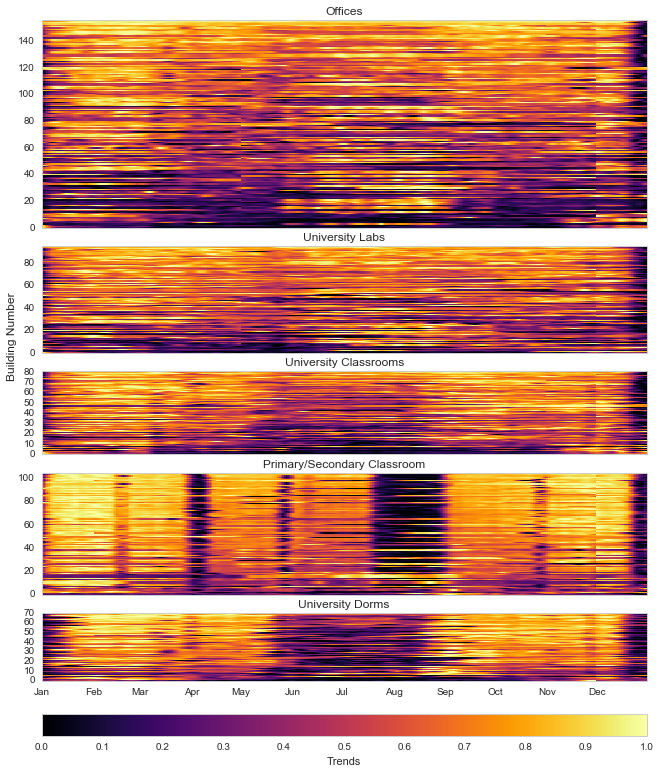

In [51]:
plotmap_subplots(temp_trend_generalized_sorted, meta, 'inferno', "Trends",
                 " ", "Building Number", " ", " ", 0, 1)
plt.savefig(os.path.join(repos_path,"reports/figures/featureoverviews/stl_weathernorm_trend_heatmap.png"));

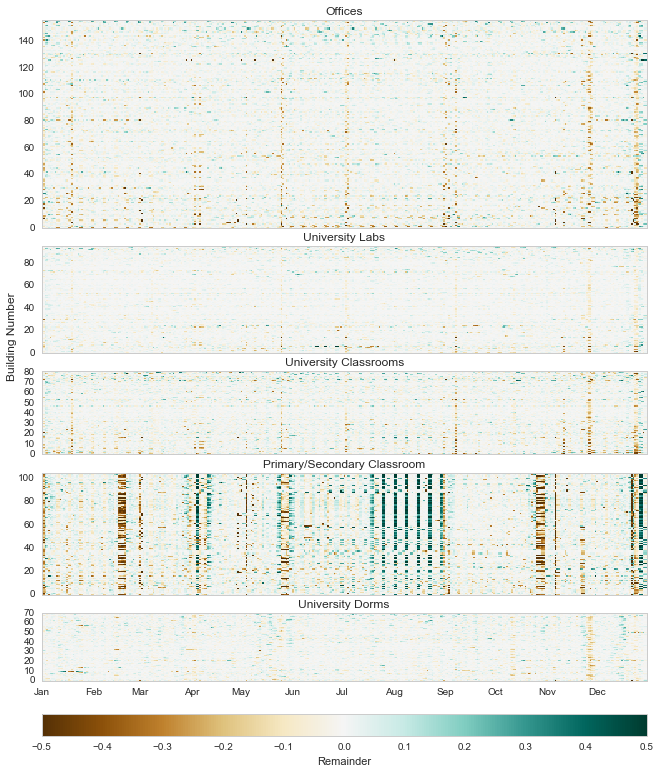

In [52]:
plotmap_subplots(temp_remainder_generalized_sorted, meta, 'BrBG', "Remainder",
                 " ", "Building Number", " ", " ", -0.5, 0.5)
plt.savefig(os.path.join(repos_path,"reports/figures/featureoverviews/stl_weathernorm_remainder_heatmap.png"));

In [49]:
temp_seasonal_sorted = temp_seasonal[list(temp_seasonal.mean().sort_values().index)]

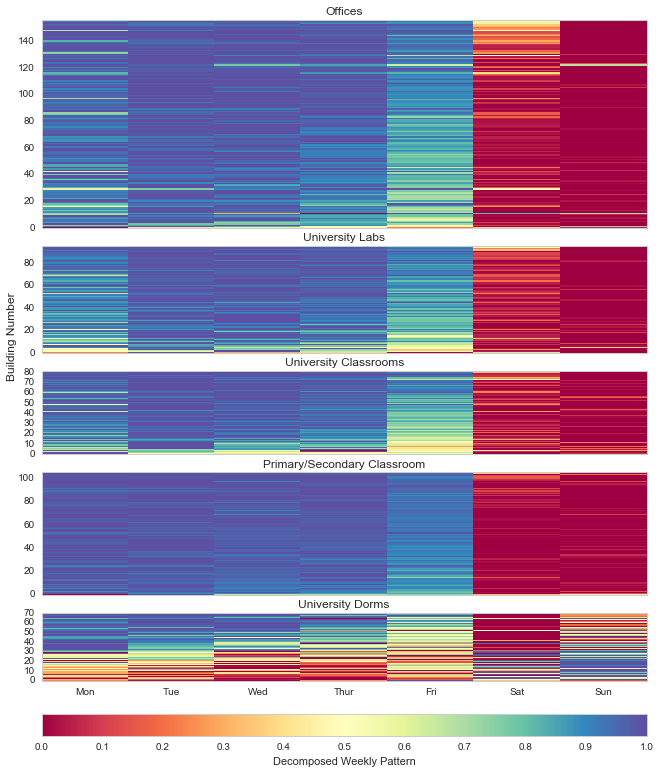

In [51]:
plotmap_subplots_weekdays(temp_seasonal_sorted, meta, 'Spectral', "Decomposed Weekly Pattern",
                 " ", "Building Number", " ", " ", 0, 1)
plt.savefig(os.path.join(repos_path,"reports/figures/featureoverviews/stl_weathernorm_weeklypattern_heatmap.png"));

In [52]:
temp_trend.to_csv(os.path.join(repos_path,"data/interim/temp_stl_weathernorm_trend.csv"))
temp_remainder.to_csv(os.path.join(repos_path,"data/interim/temp_stl_weathernorm_remainder.csv"))
temp_seasonal.to_csv(os.path.join(repos_path,"data/interim/features_stl_weathernorm_weeklypattern.csv"))

# Create input features

In [44]:
temp_trend = pd.read_csv(os.path.join(repos_path,"data/interim/temp_stl_weathernorm_trend.csv"), index_col='timestamp', parse_dates=True)
temp_remainder = pd.read_csv(os.path.join(repos_path,"data/interim/temp_stl_weathernorm_remainder.csv"), index_col='timestamp', parse_dates=True)
temp_seasonal = pd.read_csv(os.path.join(repos_path,"data/processed/features_stl_weathernorm_weeklypattern.csv"), index_col='Unnamed: 0')

In [65]:
temp_trend_features = pd.groupby(temp_trend_features,by=[temp_trend_features.index.month]).mean().T

In [67]:
temp_trend_features.head()

,1,2,3,4,5,6,7,8,9,10,11,12
PrimClass_Everett,0.536513,0.509075,0.327445,0.344663,0.562031,0.771458,0.753339,0.644481,0.725645,0.531617,0.363468,0.286622
UnivClass_Clifford,0.709070,0.848149,0.892884,0.885251,0.659863,0.633311,0.510795,0.523630,0.609859,0.633954,0.612157,0.397367
Office_Elizabeth,0.256267,0.270612,0.263553,0.239250,0.280536,0.192959,0.308037,0.799974,0.719461,0.354720,0.360625,0.127758
Office_Ellie,0.796622,0.897887,0.365302,0.128063,0.158286,0.120888,0.251161,0.419164,0.182273,0.067976,0.251848,0.551922
PrimClass_Elisabeth,0.288561,0.292820,0.289681,0.264790,0.307902,0.209571,0.338600,0.815230,0.777825,0.395250,0.401622,0.135771


In [71]:
temp_trend_features.columns = ['BG_stltrend_jan_mean','BG_stltrend_feb_mean','BG_stltrend_mar_mean','BG_stltrend_apr_mean','BG_stltrend_may_mean','BG_stltrend_jun_mean','BG_stltrend_jul_mean','BG_stltrend_aug_mean','BG_stltrend_sep_mean','BG_stltrend_oct_mean','BG_stltrend_nov_mean','BG_stltrend_dec_mean']

In [72]:
temp_trend_features

,BG_stltrend_jan_mean,BG_stltrend_feb_mean,BG_stltrend_mar_mean,BG_stltrend_apr_mean,BG_stltrend_may_mean,BG_stltrend_jun_mean,BG_stltrend_jul_mean,BG_stltrend_aug_mean,BG_stltrend_sep_mean,BG_stltrend_oct_mean,BG_stltrend_nov_mean,BG_stltrend_dec_mean
PrimClass_Everett,0.536513,0.509075,0.327445,0.344663,0.562031,0.771458,0.753339,0.644481,0.725645,0.531617,0.363468,0.286622
UnivClass_Clifford,0.709070,0.848149,0.892884,0.885251,0.659863,0.633311,0.510795,0.523630,0.609859,0.633954,0.612157,0.397367
Office_Elizabeth,0.256267,0.270612,0.263553,0.239250,0.280536,0.192959,0.308037,0.799974,0.719461,0.354720,0.360625,0.127758
Office_Ellie,0.796622,0.897887,0.365302,0.128063,0.158286,0.120888,0.251161,0.419164,0.182273,0.067976,0.251848,0.551922
PrimClass_Elisabeth,0.288561,0.292820,0.289681,0.264790,0.307902,0.209571,0.338600,0.815230,0.777825,0.395250,0.401622,0.135771
Office_Cristina,0.839288,0.935733,0.679269,0.593888,0.329307,0.238734,0.254271,0.304684,0.332050,0.509219,0.603049,0.476843
PrimClass_Jolie,0.922762,0.817917,0.882079,0.577150,0.717287,0.744024,0.471019,0.048592,0.813787,0.672734,0.895195,0.760818
PrimClass_Jaylin,0.860782,0.775988,0.853537,0.660189,0.738863,0.826139,0.606726,0.068713,0.855817,0.817905,0.874242,0.705861
Office_Jesus,0.200881,0.136252,0.290583,0.241118,0.390196,0.217305,0.737272,0.991631,0.665172,0.342440,0.020562,0.209509
PrimClass_Esmeralda,0.273141,0.252137,0.222293,0.177053,0.709719,0.727273,0.951403,0.843625,0.679532,0.507902,0.495580,0.377990


In [73]:
temp_remainder_features = pd.groupby(temp_remainder,by=[temp_remainder.index.month]).mean().T

In [74]:
temp_remainder_features.columns = ['BG_stlreminder_jan_mean','BG_stlreminder_feb_mean','BG_stlreminder_mar_mean','BG_stlreminder_apr_mean','BG_stlreminder_may_mean','BG_stlreminder_jun_mean','BG_stlreminder_jul_mean','BG_stlreminder_aug_mean','BG_stlreminder_sep_mean','BG_stlreminder_oct_mean','BG_stlreminder_nov_mean','BG_stlreminder_dec_mean']

In [80]:
temp_remainder_features.head()

,BG_stlreminder_jan_mean,BG_stlreminder_feb_mean,BG_stlreminder_mar_mean,BG_stlreminder_apr_mean,BG_stlreminder_may_mean,BG_stlreminder_jun_mean,BG_stlreminder_jul_mean,BG_stlreminder_aug_mean,BG_stlreminder_sep_mean,BG_stlreminder_oct_mean,BG_stlreminder_nov_mean,BG_stlreminder_dec_mean
building_name,,,,,,,,,,,,
PrimClass_Everett,-0.012245,-0.011414,0.004664,-0.007601,0.001115,-0.006939,0.008526,-0.013382,-0.031554,-0.036222,-0.024618,0.011158
UnivClass_Clifford,-0.003416,0.000137,-0.003628,-0.000536,-0.003436,0.002561,-0.002932,0.001821,-0.002237,-0.001009,-0.012397,0.001096
Office_Elizabeth,-0.002463,-0.008153,0.001005,0.013250,-0.015548,0.013838,-0.013123,-0.045958,-0.067360,0.016818,-0.029989,-0.028751
Office_Ellie,-0.009817,-0.056843,0.024770,-0.000282,-0.007921,0.002500,-0.009566,-0.005040,-0.011442,0.001162,-0.001434,-0.003734
PrimClass_Elisabeth,-0.005271,-0.005100,0.000912,0.011918,-0.015407,0.013626,-0.012823,-0.026403,-0.063072,0.014031,-0.030909,-0.029512


In [82]:
temp_seasonal_features = temp_seasonal.T

In [84]:
temp_seasonal_features.columns = ["BG_stlweeklypattern_mon_mean","BG_stlweeklypattern_tue_mean", "BG_stlweeklypattern_wed_mean", "BG_stlweeklypattern_thur_mean", "BG_stlweeklypattern_fri_mean","BG_stlweeklypattern_sat_mean","BG_stlweeklypattern_sun_mean"]

In [86]:
temp_seasonal_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 507 entries, PrimClass_Everett to UnivLab_Aoife
Data columns (total 7 columns):
BG_stlweeklypattern_mon_mean     507 non-null float64
BG_stlweeklypattern_tue_mean     507 non-null float64
BG_stlweeklypattern_wed_mean     507 non-null float64
BG_stlweeklypattern_thur_mean    507 non-null float64
BG_stlweeklypattern_fri_mean     507 non-null float64
BG_stlweeklypattern_sat_mean     507 non-null float64
BG_stlweeklypattern_sun_mean     507 non-null float64
dtypes: float64(7)
memory usage: 31.7+ KB


In [87]:
features = pd.concat([temp_remainder_features, temp_trend_features, temp_seasonal_features], axis=1)

In [88]:
features.index.name = "building_name"
features.columns.name = "feature_name"

In [91]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 507 entries, PrimClass_Everett to UnivLab_Aoife
Data columns (total 31 columns):
BG_stlreminder_jan_mean          507 non-null float64
BG_stlreminder_feb_mean          507 non-null float64
BG_stlreminder_mar_mean          507 non-null float64
BG_stlreminder_apr_mean          507 non-null float64
BG_stlreminder_may_mean          507 non-null float64
BG_stlreminder_jun_mean          507 non-null float64
BG_stlreminder_jul_mean          507 non-null float64
BG_stlreminder_aug_mean          507 non-null float64
BG_stlreminder_sep_mean          507 non-null float64
BG_stlreminder_oct_mean          507 non-null float64
BG_stlreminder_nov_mean          507 non-null float64
BG_stlreminder_dec_mean          507 non-null float64
BG_stltrend_jan_mean             507 non-null float64
BG_stltrend_feb_mean             507 non-null float64
BG_stltrend_mar_mean             507 non-null float64
BG_stltrend_apr_mean             507 non-null float64
BG_stltren

In [92]:
features.to_csv(os.path.join(repos_path,"data/processed/features_stl.csv"))